# Tumor Mutation Classification

In this project, we will analyze the dataset which contains tumor gene mutations and their risk category, which corresponds to their risk of malignancy in the human condition. The dataset was hand-labeled and released by the team of clinical pathologists at Memorial Sloan Kettering in 2018. Our objective of this project is to fit the dataset into our machine learning models to predict the risk category while accounting for highly unbalanced classes. Several methods for text feature generation will be explored and the resulting features will be reduced using principle component analysis (PCA). We will then use the synthetic minority over-sampling technique (SMOTE) to resample the dataset to make the numbers of categories more even. The last step is to compare the machine learning methods.

In [1]:
import pandas as pd
import boto3
import io

import re
import spacy

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from collections import Counter
import matplotlib.pyplot as plt

import csv

from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from imblearn.over_sampling import SMOTE

from sklearn import linear_model, decomposition, datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
import xgboost
print(dir(xgboost))
print('done')
#from xgboost import XGBClassifier

nlp = spacy.blank('en')

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['Booster', 'DMatrix', 'VERSION_FILE', 'XGBClassifier', 'XGBModel', 'XGBRegressor', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'absolute_import', 'callback', 'compat', 'core', 'cv', 'f', 'libpath', 'os', 'plot_importance', 'plot_tree', 'plotting', 'rabit', 'sklearn', 'to_graphviz', 'train', 'training']
done


# Preprocessing

In this section we will load in all our data and format them to the appropriate data types. The text also needs to be cleaned of all non-legitimate words, such as figure references and parentheses. This will be accomplished using regular expressions.

In [2]:
# Set up packages for loading in data
client = boto3.client('s3') #low-level functional API

resource = boto3.resource('s3') #high-level object-oriented API

In [3]:
# Load in training data labels
obj = client.get_object(Bucket='thinkful-capstone', Key='training_variants')
stream = io.BytesIO(obj['Body'].read())
training_variants = pd.read_csv(stream)

In [4]:
print(training_variants.head())
print(training_variants.shape)

   ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4
(3321, 4)


In [5]:
# Load in training data text articles
obj = client.get_object(Bucket="thinkful-capstone",Key="training_text")
raw_training_text = obj["Body"].read()
training_text = raw_training_text.decode('utf-8')
print(training_text[:10000])

ID||Text
0||Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing pheno

In [6]:
# Eliminate references and abbreviations within parentheses
print(len(training_text))
training_text = re.sub(' \(Fig \d+.+?\)', '', training_text)
training_text = re.sub(' \(Fig\. \d+.+?\)', '', training_text)
training_text = re.sub(' \(\d.*?\)', '', training_text)
training_text = re.sub(' \([A-Z]\)', '', training_text)
print(len(training_text))
print(training_text[:4000])

211296707
205598350
ID||Text
0||Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cycl

In [7]:
# Split text file into list of documents
training_list = training_text.split('||')
training_list = training_list[2:]
print(len(training_list))

3321


In [8]:
# Load training text list into dataframe
texts_df = pd.DataFrame(training_list, columns = ['text'])

# Merge text dataframe with labels dataframe
train = pd.concat([training_variants, texts_df], axis=1)
print(train.head())
print(train.shape)

   ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   

                                                text  
0  Cyclin-dependent kinases (CDKs) regulate a var...  
1   Abstract Background  Non-small cell lung canc...  
2   Abstract Background  Non-small cell lung canc...  
3  Recent evidence has demonstrated that acquired...  
4  Oncogenic mutations in the monomeric Casitas B...  
(3321, 5)


In [9]:
# Temporary cell to reduce data size
#train = train[:400]
#print(train.shape)

Now that the data is loaded into a dataframe, let's do some preliminary data exploration.

In [10]:
print(train['Class'].value_counts())

7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64


We have 3321 total datapoints to work with, and it looks like we are dealing with significant class imbalance. Class 7 has 953 datapoints, while Class 8 has only 19. We will have to address this class imbalance with our experiment design. Additionally, the labels have been anonymized, which means we cannot draw any insight about what these classes might signify. 

# Experiment Design

The prevalence of class imbalance has serious implications for our analysis. First and foremost, we must establish our scoring metric. The purpose here is to use the relevant clinical texts to predict the mutation category for each gene/mutation pair. While we want the predictions to be as accurate as possible, simple classification accuracy is not a representative way to judge models that are built on class imbalance, as they may achieve high accuracy by simply predicting the most common class every time. <br>

Given that we are working with a multi-label classifier, the most appropriate scoring metric is log loss. Log loss quantifies the accuracy of a classifier by penalising false classifications, and heavily penalises classifiers that are confident about an incorrect classification. For this reason, it is more suitable than traditional accuracy for datasets with class imbalance. <br>

When feeding our data into the predictive models, each resulting prediction is associated with a probability, and each probability is multiplied by one another to get the overall probability that all of those outcomes occurred together. As each event gets multiplied in, the final number gets smaller and smaller. So, we take the log to put the number in a more accessible range. The number is then multiplied by -1 to maintain the convention that a lower loss score is better. We will be choosing models with log loss scores closer to 0. We will also look at the precision and recall via the F1 score. Though these are not optimized for multi-label classification, they will be interesting to consider. <br>

Source: https://datawookie.netlify.com/blog/2015/12/making-sense-of-logarithmic-loss/, https://www.kaggle.com/dansbecker/what-is-log-loss

We will also try oversampling the lesser-represented categories and apply our machine learning models on the oversampled datasets, judging by their log loss scores. Oversampling can be achieved by generating duplicate datapoints or by generating new synthetic datapoints via SMOTE, the Synthetic Minority Oversampling Technique. We will use SMOTE, a feature of the imbalanced learn package. <br>

I will use various methods of feature generation including classic NLP techniques such as bag-of-words, tf-idf, and n-grams. These methods of feature generation will be applied to both the original and oversampled datasets. They will then be subjected to various machine learning models. Decision trees are known to perform well on unbalanced datasets, so this model may prevail on the original data. However, Naive Bayes is known to perform well on natural langauge, so once the dataset is oversampled it is possible that Naive Bayes will perform the best. All machine learning models will be run with a variety of hyperparameters on a variety of datasets, and the permutation with the best log-loss score will be chosen.

It is important to note that by convention, grid search always tries to maximize its score so loss functions like log loss will have to be negated such that the lowest log loss score will be the highest

# Data Cleaning

The data is relatively clean already, and contains no NaN values. It needs to be tokenized so it can be processed into readable pieces of data. We will use spaCy to tokenize the data and create a new column with a list of the tokens for each row. Furthermore, we will convert all tokens that are not stop words or punctuation to lemmas to reduce the noise from unnecessary words.

In [11]:
stop_words = set(stopwords.words('english'))
print(stop_words)

{'o', 'his', 'whom', 'having', 'off', 'over', 'did', 'now', 'doing', 'needn', 'between', 'same', 'other', 'haven', 'wasn', 'most', "you've", 'a', 'myself', "weren't", 'isn', 'had', 'been', 'was', "it's", 'each', 'so', 'will', 'ain', 'an', 's', 'have', 'hadn', 'weren', 'down', 'or', "shan't", 'yourself', 'these', 'there', 'once', "won't", 'against', 'both', 'hers', 'no', 'own', 'does', "should've", 'won', "isn't", 'shan', 'were', 'you', 'what', 'don', 'more', 'themselves', "didn't", 'ourselves', 'some', 've', 'she', 'why', 'for', 'couldn', 'here', "that'll", 'such', "hadn't", 'if', 'where', "haven't", 'doesn', 'hasn', 'and', 'during', "hasn't", 'from', 'out', 'itself', "doesn't", 'into', 'him', 'which', 'further', 'is', 'himself', 'then', 'while', 'them', 'up', "you're", "don't", 't', 'are', 'he', 'under', 'can', 'has', "shouldn't", "you'd", 'theirs', 'before', 'm', 'all', 'few', 'wouldn', 'll', 'my', 'too', 'until', "mustn't", 'that', 'the', 'with', 'very', 'they', 'their', 'am', 'just

In [12]:
print('beginning lemmatization')
train['spacy_tokens'] = train['text'].apply(lambda x: nlp(x))

def lemmatize(x):
    intermediate_lemmas = [token.lemma_.lower() for token in x
            if not token.is_punct]
    return [lemma for lemma in intermediate_lemmas
           if lemma not in stop_words
           and lemma != "-PRON-"
           and lemma != " "
           ]

train['lemmas'] = train['spacy_tokens'].apply(lambda x: lemmatize(x))
print(train.head())

beginning lemmatization
   ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   

                                                text  \
0  Cyclin-dependent kinases (CDKs) regulate a var...   
1   Abstract Background  Non-small cell lung canc...   
2   Abstract Background  Non-small cell lung canc...   
3  Recent evidence has demonstrated that acquired...   
4  Oncogenic mutations in the monomeric Casitas B...   

                                        spacy_tokens  \
0  (Cyclin, -, dependent, kinases, (, CDKs, ), re...   
1  ( , Abstract, Background,  , Non, -, small, ce...   
2  ( , Abstract, Background,  , Non, -, small, ce...   
3  (Recent, evidence, has, demonstrated, that, ac...   
4  (Oncogenic, mutations, in, the, monomeric, Cas...   

                         

Now that we have our lemmatized datapoints, we must convert them into a list of strings to feed to our feature generators.

# make sure to run grid search in tmux pane

In [13]:
# Establishing our test datasets
X = train['lemmas']
Y = train['Class']

X_lemma_documents = [
    ' '.join([str(word) for word in text])
    for text in X.values.tolist()
]

We will reduce documents to their N most common words in order to reduce unnecessary input to vectorizer. First, we will create a dictionary of all the words in the copora and their frequencies using Counter. Then we will graph the words by frequency to see how many words make up the majority of our corpora.

In [14]:
# Create a dictionary of words and frequencies
counter = Counter()

# Iterate through each document, split into words and add words/frequencies to Counter
for document in X_lemma_documents:
    words = document.split(' ')
    counter.update(words)

In [15]:
# Convert term/frequency dictionary to list sorted by frequency
word_frequencies = sorted(
                        [[key, value] for key, value in counter.items()],
                        key = lambda x: x[1],
                        reverse = True
                        )

print(word_frequencies[:2])

[['mutation', 326668], ['cell', 297261]]


Total number of terms: 228309


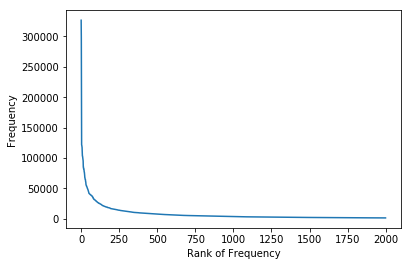

In [16]:
# Plot term frequency, trim list to 2000 most common words for easier visualization
print('Total number of terms:', len(word_frequencies))
trim_length = 2000
trim_frequencies = word_frequencies[:trim_length]
frequency_X = list(range(len(trim_frequencies)))
frequency_Y = [frequency_pair[1] for frequency_pair in trim_frequencies]
plt.plot(frequency_X, frequency_Y)
plt.xlabel('Rank of Frequency')
plt.ylabel('Frequency')
plt.show()

It appears that the term frequencies drop off after the first 250 words. After 250, the term frequencies become very sparse and will likely add no value to our model. Still, we will keep the 500 most common words for input to our feature generator to ensure that we are not losing any potentially valuable features.

In [17]:
common_length = 500
common_words = [frequency_pair[0] for frequency_pair in word_frequencies[:common_length]]

Now, in order to maintain the format of our dataframe, we must reduce each individual document to these 1000 most common words.

In [19]:
reduced_documents = []

for document in X_lemma_documents:
    words = document.split(' ')
    reduced_document = [word for word in words
                       if word in common_words]
    reduced_document = ' '.join(reduced_document)
    reduced_documents.append(reduced_document)

In [ ]:
# Export list of complete lemmatized documents filtered down to most common words to speed up future runs
def export_list_to_csv(document_list, csv_file):
    with open(csv_file, "w") as outfile:
        writer = csv.writer(outfile, lineterminator='\n')
        for val in document_list:
            writer.writerow([val])    
                  
export_list_to_csv(reduced_documents, 'reduced_document_file.csv')

# N-grams

Beyond using singular words or lemmas as features for classification, we can also use groupings of words that appear together, as they may convey more meaning than each word isolated by itself. We will create a dataset of bigrams (2 consecutive words) as groupings larger than 2 words in a dataset this small would likely create unnecessary noise without adding any insight.

# export labeled dataframe

In [ ]:
def ngrams(input_text, n):
  input_text = input_text.split(' ')
  words = []
  for i in range(len(input_text)-n+1):
    words.append(input_text[i:i+n])
  return words

joined_document_bigrams = []
corpora_bigram_list = []
counter = Counter()

for document in reduced_documents[:1]:
    joined_document_bigrams = ngrams(document, 2)
    
    for bigram in joined_document_bigrams:
        joined_bigram = bigram[0] + ' ' + bigram[1]
        joined_document_bigrams.append(joined_bigram)
        
    counter.update(joined_document_bigrams)
    corpora_bigram_list.append(joined_document_bigrams)

In [ ]:
# Convert term/frequency dictionary to sorted list
word_frequencies = sorted(
                        [[key, value] for key, value in counter.items()],
                        key = lambda x: x[1],
                        reverse = True
                        )

print(word_frequencies[:2])

# Plot term frequency, trim list to 1000 most common words for better visualization
print(len(word_frequencies))
trim_length = 1000
trim_frequencies = word_frequencies[:trim_length]
frequency_X = list(range(len(trim_frequencies)))
frequency_Y = [frequency_pair[1] for frequency_pair in trim_frequencies]
plt.plot(frequency_X, frequency_Y)
plt.xlabel('Rank of Frequency')
plt.ylabel('Frequency')
plt.show()


Again, we will look at the term frequency of each bigram to deduce how many terms we should keep.

In [ ]:
for element in joined_bigram_list[:3]:
    print(element)
    print('\n\n\n')

In [ ]:
# Create a dictionary of words and frequencies
counter = Counter()
words = []

joined_bigrams = []

for document in X_lemma_documents:
    document_bigrams = ngrams(document, 2)
    
    for bigram in document_bigrams[:10]:
        joined_bigram = bigram[0] + ' ' + bigram[1]
        joined_bigrams.append(joined_bigram)
    
    counter.update(joined_bigrams)
    
# Convert term/frequency dictionary to sorted list
word_frequencies = sorted(
                        [[key, value] for key, value in counter.items()],
                        key = lambda x: x[1],
                        reverse = True
                        )

print(word_frequencies[:2])

# Plot term frequency, trim list to 1000 most common words for better visualization
print(len(word_frequencies))
trim_length = 1000
trim_frequencies = word_frequencies[:trim_length]
frequency_X = list(range(len(trim_frequencies)))
frequency_Y = [frequency_pair[1] for frequency_pair in trim_frequencies]
plt.plot(frequency_X, frequency_Y)
plt.xlabel('Rank of Frequency')
plt.ylabel('Frequency')
plt.show()

    

# Grid Search: Feature Generation, Dimensionality Reduction, Oversampling and Machine Learning

In this cell, we will create a pipeline that iterates through several different parameters and models. For feature generation, we will attempt both tf-idf vectorization and bag-of-words vectorization, which will convert our list of strings into sparse dataframes. Bag-of-words is a simplistic representation of text that considers only term frequency and assumes that position doesn't matter. Tf-idf is a more nuanced representation of text that considers the term frequency as well the inverse document frequency, which gives more information about how significant each word is. For example, a common word such as "the" may score high in term frequency, but having high term frequency in every document would diminish its meaning and thus its tf-idf score. Both of bag-of-words and tf-idf have several parameters that will be optimized through the gridsearch. For brevity's sake, we are only tuning the max_df and min_df, which represent the maximum and minimum number of times a term should appear in any given document.

We will likely need a way to reduce dimensionality, as dimensionality reduction reduces the storage and computation requirements of our model.  We will implement some permutations of the pipeline with Truncated Singular Value Decomposition which works well with sparse data. This transformation is termed Latent Semantic Analysis, a technique that is known to combat polysemy and synonymy. For the permutations that use Truncated SVD, I chose to reduce to 500 components based on a scree plot that was generated outside of this notebook. In the scree plot, 500 components appeared to capture roughly 85% of the variance of the dataset, a well-known standard for dimensionality reduction.

Source: http://scikit-learn.org/stable/modules/decomposition.html#truncated-singular-value-decomposition-and-latent-semantic-analysis

As mentioned before, we will also implement oversampling via SMOTE to combat the class imbalance. SMOTE (Synthetic Minority Oversampling Technique) uses the K Neighbors algorithm to synthesize new datapoints that resemble the existing classes. The default number of neighbors to use is 5. In an effort to reduce computational complexity, we will hold off on tuning other parameters such as 

Finally, we will apply several different machine learning models and evaluate their performance using cross-validation with log-loss scoring. First, we will try a multinomial Naive Bayes model, which naively assumes that all features are independent from one another. The multinomial model is commonly used for NLP problems and works under the bag-of-words assumption that position doesn't matter. The sklearn MultinomialNB documentation states that "the multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work."

Source: https://web.stanford.edu/class/cs124/lec/naivebayes.pdf, http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

We will also try random forests, as ensemble models tend to be robust against overfitting. Random forest language models have been shown to generalize well to unseen data, which is important in predictive modeling. The random forest has several parameters that will be tuned with the high dimensionality of the dataset in mind.

Source: http://www.aclweb.org/anthology/W04-3242


# Logistic Regression


In [ ]:
from sklearn.linear_model import LogisticRegression

pipe = Pipeline(steps=[
    ('feat_gen', TfidfVectorizer()),
    ('reduce_dim', decomposition.TruncatedSVD()),
    ('oversample', SMOTE(k_neighbors = 5)),
    ('machine', LogisticRegression())
])

# Feature generation paramters
maxdf = [0.25, 0.5, 0.75]
mindf = [0.01, 0.05, 0.1]
# Dimensionality reduction parameters
n_components = [500]

# Oversampling parameters
smote_kind = ['regular','borderline1']

# Machine learning model parameters 
C_values = [1e-3, 1e-1, 1, 100, 1000]


param_grid = [
    # Tfidf permutations first, running through pipeline with and without dimensionality reduction/oversampling
    {
        'feat_gen': [TfidfVectorizer(max_features = 1000)],
        'feat_gen__max_df': maxdf,
        'feat_gen__min_df': mindf,
        'reduce_dim__n_components': n_components,
        'oversample__kind': smote_kind,
        'machine': [LogisticRegression(random_state=1)],
        'machine__C': C_values
    },
    {
        'feat_gen': [TfidfVectorizer(max_features = 1000)],
        'feat_gen__max_df': maxdf,
        'feat_gen__min_df': mindf,
        'oversample__kind': smote_kind,
        'machine': [LogisticRegression(random_state=1)],
        'machine__C': C_values
    },
    {
        'feat_gen': [TfidfVectorizer(max_features = 1000)],
        'feat_gen__max_df': maxdf,
        'feat_gen__min_df': mindf,
        'reduce_dim__n_components': n_components,
        'machine': [LogisticRegression(random_state=1)],
        'machine__C': C_values
    },
    {
        'feat_gen': [TfidfVectorizer(max_features = 1000)],
        'feat_gen__max_df': maxdf,
        'feat_gen__min_df': mindf,
        'machine': [LogisticRegression(random_state=1)],
        'machine__C': C_values
    },
    # Bag of words permutations next
    {
        'feat_gen': [CountVectorizer(max_features = 1000)],
        'feat_gen__max_df': maxdf,
        'feat_gen__min_df': mindf,
        'reduce_dim__n_components': n_components,
        'oversample__kind': smote_kind,
        'machine': [LogisticRegression(random_state=1)],
        'machine__C': C_values
    },
    {
        'feat_gen': [CountVectorizer(max_features = 1000)],
        'feat_gen__max_df': maxdf,
        'feat_gen__min_df': mindf,
        'oversample__kind': smote_kind,
        'machine': [LogisticRegression(random_state=1)],
        'machine__C': C_values
    },
    {
        'feat_gen': [CountVectorizer(max_features = 1000)],
        'feat_gen__max_df': maxdf,
        'feat_gen__min_df': mindf,
        'reduce_dim__n_components': n_components,
        'machine': [LogisticRegression(random_state=1)],
        'machine__C': C_values
    },
    {
        'feat_gen': [CountVectorizer(max_features = 1000)],
        'feat_gen__max_df': maxdf,
        'feat_gen__min_df': mindf,
        'machine': [LogisticRegression(random_state=1)],
        'machine__C': C_values
    }
]

grid = GridSearchCV(pipe, cv=3, param_grid=param_grid, verbose=2, scoring = 'log_loss')

In [ ]:
grid.fit(X_lemma_documents, Y)
print(f'best score: \n {grid.best_score_}')
print(f'best params:\n {grid.best_params_}')

# Random Forest

In [ ]:
pipe = Pipeline(steps=[
    ('feat_gen', TfidfVectorizer()),
    ('reduce_dim', decomposition.TruncatedSVD()),
    ('oversample', SMOTE(k_neighbors = 5)),
    # add configuration without oversampling/dim red
    ('machine', RandomForestClassifier())
])

# Feature generation paramters
maxdf = [0.25, 0.5, 0.75]
mindf = [0.01, 0.05, 0.1]

# Dimensionality reduction parameters
n_components = [500]

# Oversampling parameters
smote_kind = ['regular','borderline1']

# Machine learning model parameters 
rf_max_depth = [30, 60, 100]
#rf_max_features = [10, 20, 30]
#rf_min_samples_split = [10, 20, 30]
# look into parameter choices for RF for high dimensionality. consider higher values
rf_n_estimators = [20, 50]

param_grid = [
    # Tfidf permutations first, running through pipeline with and without dimensionality reduction/oversampling
    {
        'feat_gen': [TfidfVectorizer(max_features = 1000)],
        'feat_gen__max_df': maxdf,
        'feat_gen__min_df': mindf,
        'reduce_dim__n_components': n_components,
        'oversample__kind': smote_kind,
        'machine': [RandomForestClassifier(random_state = 1)],
        'machine__max_depth': rf_max_depth,
        'machine__max_features': rf_max_features,
        'machine__min_samples_split': rf_min_samples_split,
        'machine__n_estimators': rf_n_estimators
    },
    # Bag of words permutations next, running through all machine learning models
    {
        'feat_gen': [CountVectorizer(max_features = 1000)],
        'feat_gen__max_df': maxdf,
        'feat_gen__min_df': mindf,
        'reduce_dim__n_components': n_components,
        'oversample__kind': smote_kind,
        'machine': [RandomForestClassifier(random_state = 1)],
        'machine__max_depth': rf_max_depth,
        'machine__max_features': rf_max_features,
        'machine__min_samples_split': rf_min_samples_split,
        'machine__n_estimators': rf_n_estimators
    }
]

grid = GridSearchCV(pipe, cv=3, param_grid=param_grid, verbose=2, scoring = 'log_loss')

In [ ]:
grid.fit(X_lemma_documents, Y)
print(f'best score: \n {grid.best_score_}')
print(f'best params:\n {grid.best_params_}')

# XGBoost

In [ ]:
pipe = Pipeline(steps=[
    ('feat_gen', TfidfVectorizer()),
    ('reduce_dim', decomposition.TruncatedSVD()),
    ('oversample', SMOTE(k_neighbors = 5)),
    # add configuration without oversampling/dim red
    ('machine', XGBClassifier())
])

# Feature generation paramters
maxdf = [0.25, 0.5, 0.75]
mindf = [0.01, 0.05, 0.1]

# Dimensionality reduction parameters
n_components = [500]

# Oversampling parameters
smote_kind = ['regular','borderline1']

# Machine learning model parameters 
xg_booster = ['gbtree','gblinear']
xg_eta = [0.01, 0.1, 0.3]
xg_max_depth = [5, 10]
xg_subsample = [0.5, 1]

param_grid = [
    # Tfidf permutations first, running through pipeline with and without dimensionality reduction/oversampling
    {
        'feat_gen': [TfidfVectorizer(max_features = 1000)],
        'feat_gen__max_df': maxdf,
        'feat_gen__min_df': mindf,
        'reduce_dim__n_components': n_components,
        'oversample__kind': smote_kind,
        'machine': [XGBClassifier(random_state = 1)],
        'machine__booster': xg_booster,
        'machine__learning_rate': xg_eta,
        'machine__max_depth': xg_max_depth,
        'machine__subsample': xg_subsample
    },
    # Bag of words permutations next, running through all machine learning models
    {
        'feat_gen': [CountVectorizer(max_features = 1000)],
        'feat_gen__max_df': maxdf,
        'feat_gen__min_df': mindf,
        'reduce_dim__n_components': n_components,
        'oversample__kind': smote_kind,
        'machine': [XGBClassifier(random_state = 1)],
        'machine__booster': xg_booster,
        'machine__learning_rate': xg_eta,
        'machine__max_depth': xg_max_depth,
        'machine__subsample': xg_subsample
    }
]

grid = GridSearchCV(pipe, cv=3, param_grid=param_grid, verbose=2, scoring = 'log_loss')

In [ ]:
grid.fit(X_lemma_documents, Y)
print(f'best score: \n {grid.best_score_}')
print(f'best params:\n {grid.best_params_}')

# Reduced version of pipeline for testing

In [ ]:
pipe = Pipeline(steps=[
    ('feat_gen', TfidfVectorizer()),
    ('reduce_dim', decomposition.TruncatedSVD()),
    ('oversample', SMOTE(k_neighbors = 1)),
    # increase k neighbors to default
    # add configuration without oversampling/dim red
    ('machine', GaussianNB())
    # why gaussian?
])

# Feature generation paramters
maxdf = [0.25, 0.5, 0.75]
mindf = [0.01, 0.05, 0.1]

# Dimensionality reduction parameters
n_components = [500]
# why dim red? why 500?
# if time, show scree plot

# Oversampling parameters
smote_kind = ['regular','borderline1']

# Machine learning model parameters 
rf_max_depth = [10, 20, 30]
rf_max_features = [10, 20, 30]
rf_min_samples_split = [10, 20, 30]
# look into parameter choices for RF for high dimensionality. consider higher values
rf_n_estimators = [10, 20]
xg_booster = ['gbtree','gblinear']
xg_eta = [0.01, 0.1, 0.3]
xg_max_depth = [5, 10]
xg_subsample = [0.5, 1]



param_grid = [
    # Tfidf permutations first, running through all machine learning models
    {
        'feat_gen': [TfidfVectorizer()],
        'feat_gen__max_df': maxdf,
        'feat_gen__min_df': mindf,
        'machine': [GaussianNB()] 
    }



]

grid = GridSearchCV(pipe, cv=3, param_grid=param_grid, verbose=2, scoring = 'log_loss')

In [ ]:
grid.fit(X_lemma_documents, Y)
print(f'best params:\n {grid.best_params_}')

# Trying to figure out how I came up with my 500 PCA components

In [ ]:
import csv
import numpy as np
from operator import itemgetter
import datetime

def export_gridsearch_to_csv(gs_clf, export_file):
    with open(export_file, 'w') as outfile:
        csvwriter = csv.writer(outfile, delimiter=',')

        # Create the header using the parameter names 
        header = ["mean","std", "params"]

        csvwriter.writerow(header)
        
        sorted_by_score = sorted(gs_clf.grid_scores_, key = itemgetter(1), reverse=True)
        
        for config in sorted_by_score:
            # Get mean and standard deviation
            mean = np.abs(config[1])
            std = np.std(config[2])
            row = [mean,std, str(config[0])]

            csvwriter.writerow(row)
            
filename = datetime.datetime.utcnow().strftime('gridresults_%Y%m%d_%H:%M.csv')       
export_gridsearch_to_csv(grid, filename)

In [ ]:
import datetime
filename = datetime.datetime.utcnow().strftime('gridresults_%Y%m%d_%H%M.csv')

# Extra configurations

# Original custom tfidf vectorizer function

In [ ]:
def tfidf_vectorizer(X,Y):
    vectorizer = TfidfVectorizer(max_df=0.5,
                                 min_df=2,
                                 stop_words='english', 
                                 lowercase=True,
                                 norm=u'l2',
                                 smooth_idf=True,
                                )

    sparse_tfidf_matrix=vectorizer.fit_transform(X)
    print(f'Number of features: {sparse_tfidf_matrix.get_shape()[1]}')
    
    # Densify matrix so we can convert it to a conventional dataframe to extract X/Y
    dense_tfidf_matrix = sparse_tfidf_matrix.todense()
    df_tfidf = pd.DataFrame(dense_tfidf_matrix)
    df_tfidf['lemma_tokens'] = X
    df_tfidf['class'] = Y
    
    return df_tfidf

tfidf_unigram = tfidf_vectorizer(X_lemma_documents,Y)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

X = tfidf_unigram
sklearn_pca = PCA()
sklearn_pca.fit(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

In [ ]:
print(X_lemma_documents[:3])

In [ ]:
tfidf_bigram = tfidf_vectorizer(bigrams, Y)

In [ ]:
print(tfidf_df.head())

# Machine Learning Methods

Here, we will attempt to classify the training data using several different machine learning classifiers.

# Naive Bayes

In [ ]:
gnb = GaussianNB()
gnb.fit(tX_train, tY_train)
test_pred = gnb.predict(tX_test)
print(f'Testing Accuracy: {accuracy_score(tY_test, test_pred)}')
print(f'Cross Val Score: {cross_val_score(gnb, tX_train, tY_train, cv=3).mean()}')
print(pd.crosstab(tY_test, test_pred))

In [ ]:
tfidf = tfidf_vectorizer(
                            stop_words='english', 
                            lowercase=True,
                            norm=u'l2',
                            smooth_idf=True
                        )
nb = GaussianNB()

pipe = Pipeline(steps=[('tfidf', tfidf), ('nb', nb)])

tfidf_maxdf = [0.25, 0.5, 0.75]
tfidf_mindf = [2, 5, 20]

param_grid = [
    {
        'tfidf__max_df': tfidf_maxdf,
        'tfidf__min_df': tfidf_mindf,
    }
]

In [ ]:
grid = GridSearchCV(pipe, cv=5, n_jobs=1, param_grid=param_grid)
grid.fit(X_train, Y_train)
#print(f'best params:\n {grid.best_params_}')

In [ ]:
from sklearn import linear_model, decomposition, datasets

pipe = Pipeline([
    ('feat_gen', tfidf_vectorizer()),
    ('reduce_dim', decomposition.PCA())
    ('classify', GaussianNB())
])

tfidf_maxdf = [0.25, 0.5, 0.75]
tfidf_mindf = [2, 5, 20]

param_grid_1 = [
    {
        'feat_gen': [tfidf_vectorizer(                            
                                        stop_words='english', 
                                        lowercase=True,
                                        norm=u'l2',
                                        smooth_idf=True
                                    )],
        'feat_gen__max_df': tfidf_maxdf,
        'feat_gen__min_df': tfidf_mindf,
        'classify__C': C_OPTIONS
    },
    {
        'feat_gen': [SelectKBest(chi2)],
        'feat_gen__k': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
]

param_grid_2 = dict(feat_gen=[tfidf_vectorizer(), count_vectorizer()],
                    reduce_dim = [PCA(), tSNE()]
                    clf = [GaussianNB()])


grid = GridSearchCV(pipe, cv=3, n_jobs=1, param_grid=param_grid)
grid.fit(X, Y)

##### needs to use a real class not a custom function
##### input must be X list of strings (each string corresponds to a single document) and Y of same size